In [38]:
from typing import List, Tuple, Iterable
import sys
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import copy
import scipy
import qiskit
from qiskit import opflow
from qiskit.opflow.primitive_ops import PauliSumOp

In [2]:
def ising_hamiltonian(pauli_list: List[Tuple[str, float]]) -> PauliSumOp:
    return PauliSumOp.from_list(pauli_list)

def get_thermal_state(H: PauliSumOp, beta: float) -> qiskit.quantum_info.DensityMatrix:
    H = H.mul(-1 * beta) # returns -beta*H
    exp_H = scipy.linalg.expm(H.to_matrix()) # returns e^H
    partition_function = np.trace(exp_H)
    return qiskit.quantum_info.DensityMatrix(exp_H / partition_function)

-1.0 * ZZ
- 1.0 * IZ
+ 1.0 * ZI


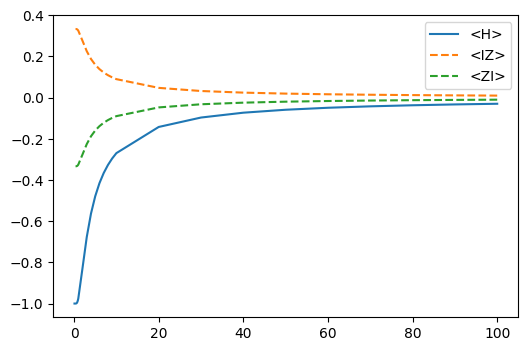

In [3]:
temp_range = list(np.arange(100, 1, -10)) + list(np.arange(9,0,-1)) + list(np.arange(0.9, 0, -0.1))

pauli_list = [('ZZ', -1), ('IZ', -1), ('ZI', 1)]
H = ising_hamiltonian(pauli_list)
print(H)
energy = []
avg_mag = []
for t in temp_range:
    beta = 1/t    
    rho = get_thermal_state(H, beta)
    energy.append(rho.expectation_value(H).real)
    spin0 = rho.expectation_value(PauliSumOp.from_list([('IZ', 1)])).real
    spin1 = rho.expectation_value(PauliSumOp.from_list([('ZI', 1)])).real
    avg_mag.append((spin0, spin1))
    
fig, ax = plt.subplots(dpi=100)
ax.plot(temp_range, energy, label='<H>')
ax.plot(temp_range, [m[0] for m in avg_mag], ls='--', label='<IZ>')
ax.plot(temp_range, [m[1] for m in avg_mag], ls='--', label='<ZI>')
ax.legend()

In [76]:
class QuantumBoltzmannMachine:
    def __init__(self, graph: nx.Graph, visible_nodes: List[int], hidden_nodes: List[int]) -> None:
        '''
        Quantum Boltzmann Machine, Mohammad H. Amin, Evgeny Andriyash, Jason Rolfe, Bohdan Kulchytskyy, and Roger Melko
        PRX 8, 021050 (2018)
        
        A quantum algorithm to train neural netowrks using low-depth circuits,
        Guillaume Verdon, Michael Broughton, Jacob Biamonte
        '''
        self.graph = graph
        self.num_units = len(list(self.graph.nodes))
        
        # Check valid input
        for i, j in zip(sorted(visible_nodes + hidden_nodes), range(self.num_units)):
            if i != j:
                raise ValueError(f"The given visible: {visible_nodes} and hidden: {hidden_nodes} nodes are invalid for a BM with {self.num_units} nodes")
        
        if len(visible_nodes) + len(hidden_nodes) != self.num_units:
            raise ValueError(f"The given visible: {visible_nodes} and hidden: {hidden_nodes} nodes are invalid for a BM with {self.num_units} nodes")
        
        for v1, v2 in self.graph.edges:
            if (v1 in hidden_nodes and v2 in hidden_nodes) or (v1 in visible_nodes and v2 in visible_nodes):
                raise ValueError("Only Restricted Boltzmann Machines are currently supported")
        
        self.visible_nodes = visible_nodes
        self.hidden_nodes = hidden_nodes
        self.visible_node_map = {node: index for index, node in enumerate(self.visible_nodes)}
        
        # Parameter initialization
        self.single_params = np.array([np.random.uniform(low=-1.0, high=1.0) for _ in range(self.num_units)])
        self.double_params = {edge: np.random.uniform(low=-1.0, high=1.0) for edge in self.graph.edges}
    
    
    def _gen_states(self, n: int) -> List[Tuple[int]]:
        bitstrings = []
        for i in range(int(2**n)):
            bitstrings.append(f'{i:0{n}b}')
            
        states = []
        for bitstr in bitstrings:
            state = [1 if b == '0' else -1 for b in bitstr]
            states.append(tuple(state))
        
        return states
    
    
    def get_distribution(self, beta: float) -> dict:
        # Eq. 13 Amin et al.
        
        # Get all possible visible and total states
        #    gen_states returns the states in order: 0, 1, 2, 3, ...
        visible_states = self._gen_states(len(self.visible_nodes))
        all_states = self._gen_states(self.num_units)
        
        # Get the current thermal state described by the QBM
        rho = self.get_thermal_state(self.get_hamiltonian(), beta) # What value should beta be?
        
        probability_dist = {}
        for visible_state in visible_states:
            # Construct the projector matrix
            projector = []
            for i, total_state in enumerate(all_states):
                row = np.zeros(int(2**self.num_units)) # Constructing an exponentially large matrix...
                cur_vis_state = tuple([total_state[j] for j in self.visible_nodes])
                if cur_vis_state == visible_state:
                    row[i] = 1
                projector.append(row)

            projector = qiskit.quantum_info.Operator(np.array(projector))
            probability_dist[visible_state] = np.trace(projector.dot(rho))
        
        return probability_dist
    
    
    def log_likelihood(self, data_dist: dict, model_dist: dict) -> float:
        # Eq. 17 of Amin et al.
        visible_states = self._gen_states(len(self.visible_nodes))
        
        log_likelihood = 0.0
        for visible_state in visible_states:
            p_v_data = data_dist.get(visible_state, 0)
            p_v_model = model_dist.get(visible_state, 0)
            print(f'Visible state: {visible_state}, p_v_data = {p_v_data:.3f}, p_v_model = {p_v_model:.3f}')
            if p_v_model > 0:
                log_likelihood -= p_v_data * np.log2(p_v_model / p_v_data)
        
        return log_likelihood
    
    
    def plot_dist(self, dist: dict, data_dist: dict = None) -> None:
        fig, ax = plt.subplots(figsize=[15,5])
        xvals, yvals = [], []
        for key, val in dist.items():
            bitstring = ''.join(['1' if b == -1 else '0' for b in key])
            xvals.append(int(bitstring, 2))
            yvals.append(val)
            
        width = 0.4
        
        ax.bar(xvals, yvals, color='palegreen', label=r'$P^{model}_v$', align='edge', width=width)
        
        if data_dist is not None:
            data_xvals, data_yvals = [], []
            for key, val in data_dist.items():
                bitstring = ''.join(['1' if b == -1 else '0' for b in key])
                data_xvals.append(int(bitstring, 2))
                data_yvals.append(val)
            ax.bar(data_xvals, data_yvals, color='lightsalmon', label=r'$P^{data}_v$', align='edge', width=-width)
            
        plt.grid(alpha=.4, linestyle='--')
        plt.legend(fontsize=14)
        plt.xlabel(r'Visible state', fontsize=14)
        plt.ylabel('Probability', fontsize=14)
        plt.show()
        plt.close()
    
    
    def get_hamiltonian(self, clamped: bool = False) -> PauliSumOp:
        # Eq 16 of Amin et al.
        pauli_list = []
        
        # single terms
        for node, param in enumerate(self.single_params):
            if clamped and node in self.visible_nodes:
                continue
            pauli = ['I'] * self.num_units
            pauli[node] = 'Z'
            pauli_list.append((''.join(reversed(pauli)), -1*param))
        
        # double terms
        for edge in self.graph.edges():
            if clamped and edge[0] in self.visible_nodes and edge[1] in self.visible_nodes:
                continue
            param = self.double_params[edge]
            pauli = ['I'] * self.num_units
            pauli[edge[0]] = 'Z'
            pauli[edge[1]] = 'Z'
            pauli_list.append((''.join(reversed(pauli)), -1*param))
        
        return PauliSumOp.from_list(pauli_list)


    def get_thermal_state(self, H: PauliSumOp, beta: float) -> qiskit.quantum_info.DensityMatrix:
        H = H.mul(-1 * beta) # returns -beta*H
        exp_H = scipy.linalg.expm(H.to_matrix()) # returns e^H
        partition_function = np.trace(exp_H)
        return qiskit.quantum_info.DensityMatrix(exp_H / partition_function)


    def compute_clamped_expectation(self, i: int, visible_state: Tuple[int]) -> float:
        # Eq 34 of Amin et al.
        b_i_eff = self.single_params[i] + sum([self.double_params.get(tuple(sorted((i,j))), 0) * v_j for j, v_j in enumerate(visible_state)])
        D_i = np.sqrt(b_i_eff**2) # modify this when updating the Hamiltonian to actually be quantum
        return (b_i_eff / D_i) * np.tanh(D_i)
    
    
    def exact_optimization(self, data_dist: dict, step_size: float = 0.1, cutoff: float = 1e-3,
                           max_epoch: int = 100, verbose: int = 0, beta: float = 10.0) -> None:
        cur_epoch = 1
        progress = 100
        cur_log_likelihood = self.log_likelihood(data_dist, self.get_distribution(beta=beta))
        while progress > cutoff and cur_epoch <= max_epoch:
            # Get clamped and unclamped Hamiltonians
            unclamped_hamiltonian = self.get_hamiltonian(clamped=False)
            #clamped_hamiltonian   = self.get_hamiltonian(clamped=True)
            
            # Get their respective low-temperature thermal states
            unclamped_rho = self.get_thermal_state(unclamped_hamiltonian, beta)
            #clamped_rho = self.get_thermal_state(clamped_hamiltonian, beta)
            
            # Update parameters, Theta(n) -> Theta(n+1)
            new_single_params = copy.copy(self.single_params)
            new_double_params = copy.copy(self.double_params)
            
            # First, update the single parameters 
            single_param_deltas = []
            for i in range(len(self.single_params)):
                # positive phase, <z_i>_v -> clamped
                positive_phase = 0
                for visible_state, p_v_data in data_dist.items():
                    if i in self.visible_nodes:
                        expectation = visible_state[self.visible_node_map[i]]
                    else:
                        expectation = self.compute_clamped_expectation(i, visible_state)
                    positive_phase += p_v_data * expectation
                
                # negative phase, <z_i> -> unclamped
                paulistr = ['I'] * self.num_units
                paulistr[i] = 'Z'
                paulistr = ''.join(reversed(paulistr))
                negative_phase = unclamped_rho.expectation_value(PauliSumOp.from_list([(paulistr, 1)])).real
                
                new_single_params[i] += step_size * (positive_phase - negative_phase)
                
            # Second, update the double parameters
            double_param_deltas = {}
            for edge in self.double_params.keys():
                # positive phase, <z_i*z_j>_v -> clamped
                positive_phase = 0
                for visible_state, p_v_data in data_dist.items():
                    if edge[0] in self.visible_nodes:
                        expectation = visible_state[self.visible_node_map[edge[0]]] * self.compute_clamped_expectation(edge[1], visible_state)
                    elif edge[1] in self.visible_nodes:
                        expectation = visible_state[self.visible_node_map[edge[1]]] * self.compute_clamped_expectation(edge[0], visible_state)
                    else:
                        raise Exception('Something went wrong, expected an RBM graph structure')
                    positive_phase += p_v_data * expectation
                
                # negative phase, <z_i*z_j> -> unclamped
                paulistr = ['I'] * self.num_units
                paulistr[edge[0]] = 'Z'
                paulistr[edge[1]] = 'Z'
                paulistr = ''.join(reversed(paulistr))
                negative_phase = unclamped_rho.expectation_value(PauliSumOp.from_list([(paulistr, 1)])).real
                
                new_double_params[edge] += step_size * (positive_phase - negative_phase)
                
            # Perform the update
            self.single_params = new_single_params
            self.double_params = new_double_params
            
            new_log_likelihood = self.log_likelihood(data_dist, self.get_distribution(beta=beta))
            progress = abs(new_log_likelihood - cur_log_likelihood)
            
            if verbose > 0 and (cur_epoch-1) % 10 == 0:
                print(f'Finished epoch {cur_epoch}:')
                print(f'\t|L_i - L_i+1| = |{cur_log_likelihood:.5f} - {new_log_likelihood:.5f}| = {progress:.5f}')
            
            cur_log_likelihood = new_log_likelihood
            
            cur_epoch += 1

[0, 1] [2, 3, 4]
[ 0.21996877 -0.70714197  0.40033757 -0.62732137 -0.0674445 ]
{(0, 2): -0.5199834368094505, (0, 3): -0.8225041631642853, (0, 4): -0.5851655750998803, (2, 1): 0.08803349931205884, (3, 1): -0.9394578309758235, (4, 1): -0.5147314324176313}
-0.4003375698003271 * IIZII
+ 0.6273213702978964 * IZIII
+ 0.06744450138254376 * ZIIII
+ 0.5199834368094505 * IIZIZ
+ 0.8225041631642853 * IZIIZ
+ 0.5851655750998803 * ZIIIZ
- 0.08803349931205884 * IIZZI
+ 0.9394578309758235 * IZIZI
+ 0.5147314324176313 * ZIIZI


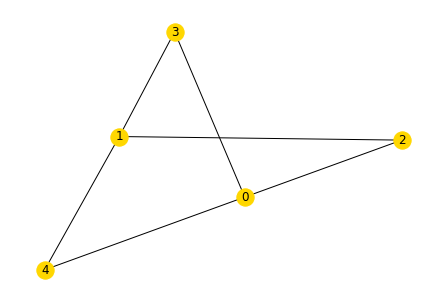

In [77]:
G = nx.Graph()
G.add_edges_from([(0,2), (0,3), (0,4),
                  (1,2), (1,3), (1,4)])
nx.draw_spring(G, with_labels=True, node_color='gold')

visible = [0,1]
hidden = [2, 3, 4]
bm = QuantumBoltzmannMachine(G, visible, hidden)
print(bm.visible_nodes, bm.hidden_nodes)
print(bm.single_params)
print(bm.double_params)
print(bm.get_hamiltonian(clamped=True))

(1+0j)
Visible state: (1, 1), p_v_data = 0.200, p_v_model = 1.000+0.000j
Visible state: (1, -1), p_v_data = 0.200, p_v_model = 0.000+0.000j
Visible state: (-1, 1), p_v_data = 0.200, p_v_model = 0.000+0.000j
Visible state: (-1, -1), p_v_data = 0.400, p_v_model = 0.000+0.000j
Log likelihood: L(data, model) = 137.013+0.000j


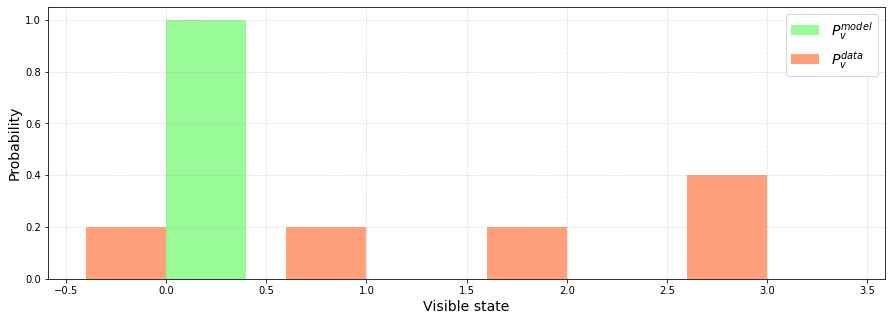

In [78]:
data_dist = {(-1, -1): 0.40, (-1, 1): 0.2, (1, -1): 0.2, (1, 1): 0.2}
beta = 100

model_dist = bm.get_distribution(beta=beta)
print(sum(model_dist.values()))
llh = bm.log_likelihood(data_dist, model_dist)
print(f'Log likelihood: L(data, model) = {llh:.3f}')
bm.plot_dist(model_dist, data_dist=data_dist)

Visible state: (1, 1), p_v_data = 0.200, p_v_model = 1.000+0.000j
Visible state: (1, -1), p_v_data = 0.200, p_v_model = 0.000+0.000j
Visible state: (-1, 1), p_v_data = 0.200, p_v_model = 0.000+0.000j
Visible state: (-1, -1), p_v_data = 0.400, p_v_model = 0.000+0.000j
Visible state: (1, 1), p_v_data = 0.200, p_v_model = 1.000+0.000j
Visible state: (1, -1), p_v_data = 0.200, p_v_model = 0.000+0.000j
Visible state: (-1, 1), p_v_data = 0.200, p_v_model = 0.000+0.000j
Visible state: (-1, -1), p_v_data = 0.400, p_v_model = 0.000+0.000j
Finished epoch 1:
	|L_i - L_i+1| = |137.01317+0.00000j - 127.72634+0.00000j| = 9.28682
Visible state: (1, 1), p_v_data = 0.200, p_v_model = 1.000+0.000j
Visible state: (1, -1), p_v_data = 0.200, p_v_model = 0.000+0.000j
Visible state: (-1, 1), p_v_data = 0.200, p_v_model = 0.000+0.000j
Visible state: (-1, -1), p_v_data = 0.400, p_v_model = 0.000+0.000j
Visible state: (1, 1), p_v_data = 0.200, p_v_model = 1.000+0.000j
Visible state: (1, -1), p_v_data = 0.200, p

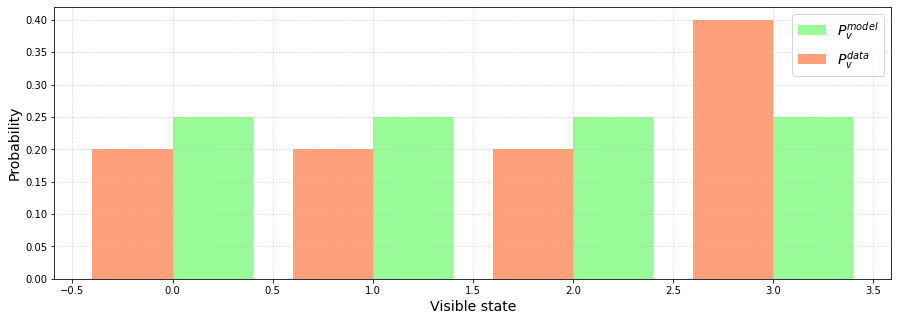

In [79]:
step_size = 0.01
cutoff = 1e-7
max_epoch = 500

bm.exact_optimization(data_dist, step_size=step_size, cutoff=cutoff, max_epoch=max_epoch, verbose=1,
                      beta=beta)
print('\nFinal Distribution:\n')
bm.plot_dist(bm.get_distribution(beta), data_dist=data_dist)